In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision import utils
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:

class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 25, kernel_size=12),
            nn.BatchNorm2d(25),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(25, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.fc1 = nn.Linear(4 * 4 * 64, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
        self.type = 'CNN'

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)

        return out


In [3]:
def create_dataloader():
    # MNIST dataset
    train_dataset = torchvision.datasets.MNIST(root='data',
                                               train=True,
                                               download=True,
                                               transform=transforms.ToTensor())

    test_dataset = torchvision.datasets.MNIST(root='data',
                                              train=False,
                                              download=True,
                                              transform=transforms.ToTensor())

    # Data loader
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=64,
                                               shuffle=True)

    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=64,
                                              shuffle=False)

    return train_loader, test_loader

In [4]:
def train(train_loader, model, criterion, optimizer, num_epochs):
    # Train the model
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        for step, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            if model.type == 'MLP':
                images = images.reshape(-1, 28 * 28)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (step + 1) % 100 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                      .format(epoch + 1, num_epochs, step + 1, total_step, loss.item()))

In [5]:
def test(test_loader, model):
    # Test the model
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            if model.type == 'MLP':
                images = images.reshape(-1, 28 * 28)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

In [6]:


def visTensor(tensor, ch=0, allkernels=False, nrow=5, padding=1): 
    n,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

Epoch [1/5], Step [100/938], Loss: 0.4132
Epoch [1/5], Step [200/938], Loss: 0.2820
Epoch [1/5], Step [300/938], Loss: 0.1508
Epoch [1/5], Step [400/938], Loss: 0.1833
Epoch [1/5], Step [500/938], Loss: 0.0834
Epoch [1/5], Step [600/938], Loss: 0.2059
Epoch [1/5], Step [700/938], Loss: 0.1215
Epoch [1/5], Step [800/938], Loss: 0.1454
Epoch [1/5], Step [900/938], Loss: 0.0294
Epoch [2/5], Step [100/938], Loss: 0.1506
Epoch [2/5], Step [200/938], Loss: 0.0649
Epoch [2/5], Step [300/938], Loss: 0.0760
Epoch [2/5], Step [400/938], Loss: 0.1031
Epoch [2/5], Step [500/938], Loss: 0.0455
Epoch [2/5], Step [600/938], Loss: 0.0477
Epoch [2/5], Step [700/938], Loss: 0.0169
Epoch [2/5], Step [800/938], Loss: 0.1452
Epoch [2/5], Step [900/938], Loss: 0.0125
Epoch [3/5], Step [100/938], Loss: 0.0563
Epoch [3/5], Step [200/938], Loss: 0.0785
Epoch [3/5], Step [300/938], Loss: 0.0127
Epoch [3/5], Step [400/938], Loss: 0.0173
Epoch [3/5], Step [500/938], Loss: 0.0149
Epoch [3/5], Step [600/938], Loss:

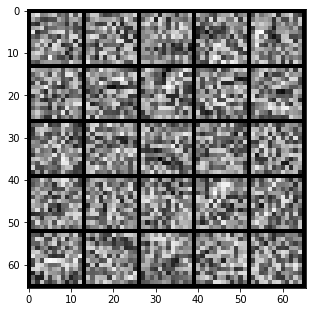

In [7]:
if __name__ == '__main__':
    train_loader, test_loader = create_dataloader()

    model = ConvNet()

    model.to(device)


    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    train(train_loader, model, criterion, optimizer, num_epochs=5)
    test(test_loader, model)
    filter = model.layer1[0].weight.data.cpu().clone()
    visTensor(filter, ch=0, allkernels=False)